# Diffusion on an Exponentially Tilted Uniform Measure on a Line

In this notebook we:

1. Start with a uniform variable \(t\) on \([0,1]\) (with mean 0.5) and define a linear mapping
   \[
     f(t) = (t, 2t-1)
   \]
   so that the data lie on a straight line in the \(xy\)-plane.

2. Compute an exponentially tilted measure of \(t\) with density
   \[
     p_\theta(t) \propto \exp(\theta\,t)
   \]
   and use binary search to find \(\theta\) that gives a new mean (e.g. 0.7).

3. Use rejection sampling to generate samples from the tilted measure.

4. Map these samples through \(f(t)\) to obtain 2D points.

5. Train a diffusion model on these data and generate samples via the analytical method, DDIM, and DDPM.


## 1. Setup: Imports and Helper Functions

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

# Set a device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 2. Define the Linear Mapping \(f(t)\)

In [23]:
def f(t):
    # return np.stack([10*(t - 0.5), 10*(t - 0.5)], axis=1)
    t = np.pi * (2 * t)

    x = 5 * np.cos(t)
    y = 5 * np.sin(t)
    data = np.stack([x, y], axis=1)
    return data


def inverse_f(data):
    """
    Given an array of points with shape (n,2) coming from f(t) = (5*cos(2*pi*t), 5*sin(2*pi*t)),
    recover the corresponding t values.
    """
    angles = np.arctan2(data[:, 1], data[:, 0])
    # Ensure angles are in [0, 2*pi]
    angles[angles < 0] += 2 * np.pi
    t = angles / (2 * np.pi)
    return t

def inverse_f_torch(points):
    """
    Torch version to compute t = f^-1(x,y) for points of shape (B,2).
    Returns a tensor of shape (B,1).
    """
    angle = torch.atan2(points[:, 1], points[:, 0])
    angle = torch.where(angle < 0, angle + 2 * np.pi, angle)
    t = angle / (2 * np.pi)
    return t.unsqueeze(1)

## 3. Generate Uniform Samples and Plot

We first generate samples of \(t\) from a uniform distribution (mean 0.5) and map them using \(f(t)\).

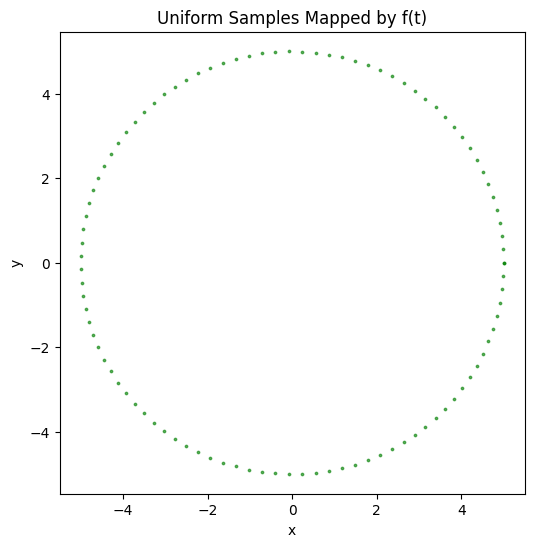

In [24]:
n_samples = 100
t_uniform = np.linspace(0, 1, n_samples)
data_uniform = f(t_uniform)

plt.figure(figsize=(6, 6))
plt.scatter(data_uniform[:, 0], data_uniform[:, 1], s=3, color="green", alpha=0.6)
plt.title("Uniform Samples Mapped by f(t)")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.show()

## 4. Exponential Tilting of the Measure

We wish to tilt the uniform distribution so that the new mean is, say, 0.7. For a density

$
p_\theta(t) \propto \exp(\theta\, t), \quad t\in[0,1]
$

We then use a binary search to find the value of $\theta$.

In [25]:
def weighted_mean(theta, t):
    weights = np.exp(theta * t)
    return np.sum(t * weights) / np.sum(weights)


def find_theta(target_mean, t, tol=1e-10, max_iter=100):
    low, high = -10, 10.0  # search interval
    for i in range(max_iter):
        mid = (low + high) / 2
        m = weighted_mean(mid, t)
        if abs(m - target_mean) < tol:
            return mid
        elif m < target_mean:
            low = mid
        else:
            high = mid
    return mid


theta_target = find_theta(0.7, t_uniform)
print(
    f"Found theta: {theta_target:.6f}, which gives mean = {weighted_mean(theta_target, t_uniform):.6f}"
)

Found theta: 2.613027, which gives mean = 0.700000


## 6. Diffusion Experiments on the Tilted Data

We now train a diffusion model on the tilted data and generate samples using three methods:

- **Analytical Sampling**: Using a kernel–based conditional expectation.
- **DDIM Sampling**
- **DDPM Sampling**

First, we define the necessary diffusion parameters and a simple diffusion model.

### 6.1 Diffusion Utilities

In [26]:
def get_diffusion_params(T, device):
    betas = np.linspace(1e-4, 0.02, T)  # linear schedule
    alphas = 1 - betas
    alpha_bars = np.cumprod(alphas)
    betas = torch.tensor(betas, dtype=torch.float32, device=device)
    alphas = torch.tensor(alphas, dtype=torch.float32, device=device)
    alpha_bars = torch.tensor(alpha_bars, dtype=torch.float32, device=device)
    return betas, alphas, alpha_bars


class DiffusionModel(nn.Module):
    def __init__(self, time_embedding_dim=32, hidden_dim=128, num_layers=8):
        super().__init__()
        self.time_embedding = nn.Sequential(
            nn.Linear(1, time_embedding_dim),
            nn.ReLU(),
            nn.Linear(time_embedding_dim, time_embedding_dim),
        )
        layers = [nn.Linear(2 + time_embedding_dim, hidden_dim), nn.ReLU()]
        for _ in range(num_layers):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, 2))
        self.net = nn.Sequential(*layers)

    def forward(self, x, t):
        t_emb = self.time_embedding(t)
        x_input = torch.cat([x, t_emb], dim=1)
        return self.net(x_input)

### 6.2 Training the Diffusion Model on the Tilted Data

We use the tilted data (already mapped to 2D by \(f\)) as the training set.

In [ ]:
def train_model_on_line(
    data, theta, num_epochs=1000, T=100, batch_size=128, device=device, print_every=200
):
    data_tensor = torch.tensor(data, dtype=torch.float32)
    dataset = TensorDataset(data_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    betas, alphas, alpha_bars = get_diffusion_params(T, device)
    model = DiffusionModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    total_epochs = num_epochs * T
    print_every = print_every * T

    model.train()
    for epoch in range(1, total_epochs + 1):
        total_loss = 0
        for (x0,) in dataloader:
            x0 = x0.to(device)
            B = x0.shape[0]
            # Sample a random time index for each sample
            t = torch.randint(0, T, (B,), device=device)
            noise = torch.randn_like(x0)
            sqrt_alpha_bar = torch.sqrt(alpha_bars[t]).unsqueeze(1)
            sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bars[t]).unsqueeze(1)
            x_t = sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise
            t_norm = (t.float() / T).unsqueeze(1)
            
            noise_pred = model(x_t, t_norm)

            loss = (torch.exp(theta * inverse_f_torch(x0)) * ((noise_pred - noise) ** 2)).mean()
            total_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % print_every == 0 or epoch == 1:
            print(f"Epoch {epoch // T}/{num_epochs}, Loss: {loss.item():.4f}")
    return model, betas, alphas, alpha_bars

### 6.3 Sampling Functions: DDPM, DDIM, and Analytical Sampling

These functions generate a sequence of samples (trajectories) through the reverse process.

In [28]:
@torch.no_grad()
def sample_ddpm(model, num_samples, T, betas, alphas, alpha_bars, device=device):
    model.eval()
    x = torch.randn(num_samples, 2, device=device)
    samples = [x.cpu().numpy()]
    for t in reversed(range(1, T)):
        t_tensor = torch.full((num_samples, 1), t / T, device=device)
        eps = model(x, t_tensor)
        beta_t = betas[t]
        alpha_t = alphas[t]
        alpha_bar_t = alpha_bars[t]
        alpha_bar_prev = alpha_bars[t - 1]
        z = torch.randn_like(x)
        x0 = (1 / torch.sqrt(alpha_bar_t)) * (x - (torch.sqrt(1 - alpha_bar_t) * eps))
        mu = (torch.sqrt(alpha_t) * (1 - alpha_bar_prev) / (1 - alpha_bar_t)) * x + (
            torch.sqrt(alpha_bar_prev) * beta_t / (1 - alpha_bar_t)
        ) * x0
        noise = torch.sqrt(beta_t * (1 - alpha_bar_prev) / (1 - alpha_bar_t)) * z
        x = mu + noise
        samples.append(x.cpu().numpy())
    return np.array(samples)


@torch.no_grad()
def sample_ddim(model, num_samples, T, alpha_bars, device=device):
    model.eval()
    x = torch.randn(num_samples, 2, device=device)
    samples = [x.cpu().numpy()]
    for t in reversed(range(1, T)):
        t_tensor = torch.full((num_samples, 1), t / T, device=device)
        eps = model(x, t_tensor)
        alpha_bar_t = alpha_bars[t]
        sqrt_alpha_bar_t = torch.sqrt(alpha_bar_t)
        sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar_t)
        x0_pred = (x - sqrt_one_minus_alpha_bar_t * eps) / sqrt_alpha_bar_t
        alpha_bar_prev = alpha_bars[t - 1]
        sqrt_alpha_bar_prev = torch.sqrt(alpha_bar_prev)
        sqrt_one_minus_alpha_bar_prev = torch.sqrt(1 - alpha_bar_prev)
        x = sqrt_alpha_bar_prev * x0_pred + sqrt_one_minus_alpha_bar_prev * eps
        samples.append(x.cpu().numpy())
    return np.array(samples)


def compute_E_x_given_y_vectorized(x_points, sigma, grid_points, theta):
    """
    Compute the conditional expectation E[x|y] for each point in grid_points,
    using a Gaussian kernel with standard deviation sigma and an exponential tilt.
    The tilt is applied as exp(theta * t) where t is computed from x_points using inverse_f.
    
    Parameters:
      x_points (np.ndarray): Array of shape (M, 2) of data points.
      sigma (float): Standard deviation for the Gaussian kernel.
      grid_points (np.ndarray): Array of shape (N, 2) of query grid points.
      theta (float): Exponential tilting parameter.
    
    Returns:
      np.ndarray: An array of shape (N, 2) with the weighted conditional expectation at each grid point.
    """
    # Compute pairwise squared Euclidean distances between grid points and data points.
    diff = grid_points[:, None, :] - x_points[None, :, :]
    distances_sq = np.sum(diff**2, axis=2)
    
    # Compute the Gaussian kernel exponent.
    exponent = -distances_sq / (2 * sigma**2)
    
    # Subtract maximum exponent for numerical stability.
    kernel_weights = np.exp(exponent)
    t_points = inverse_f(x_points)
    
    # Compute the tilt weights.
    tilt_weights = np.exp(theta * t_points)  # shape (M,)
    
    # Multiply kernel weights by the tilt weights for each data point.
    weights = kernel_weights * tilt_weights[None, :]
    
    # Compute the weighted conditional expectation.
    numerator = weights @ x_points
    denominator = np.sum(weights, axis=1, keepdims=True)
    
    # Return the expectation with a small epsilon added to avoid division by zero.
    return numerator / (denominator + 1e-12)


@torch.no_grad()
def sample_analytically(x_points, grid_points, T, theta, device=device):
    betas, alphas, alpha_bars = get_diffusion_params(T, device)
    x = torch.tensor(grid_points, dtype=torch.float32, device=device)
    samples = [x.cpu().numpy()]
    for t in reversed(range(1, T)):
        beta_t = betas[t]
        alpha_bar_t = alpha_bars[t]
        alpha_bar_prev = alpha_bars[t - 1]
        sigma = torch.sqrt(beta_t * (1 - alpha_bar_prev) / (1 - alpha_bar_t)).item()
        x_np = x.cpu().numpy()
        x0_np = compute_E_x_given_y_vectorized(x_points, sigma, x_np, theta)
        x0 = torch.tensor(x0_np, dtype=torch.float32, device=device)
        mu = (torch.sqrt(alphas[t]) * (1 - alpha_bar_prev) / (1 - alpha_bar_t)) * x + (
            torch.sqrt(alpha_bar_prev) * beta_t / (1 - alpha_bar_t)
        ) * x0
        z = torch.randn_like(x)
        x = mu + sigma * z
        samples.append(x.cpu().numpy())
    return np.array(samples)

### 6.4 Combined Figure: Comparing the Data and Sampling Methods

This function trains the diffusion model on the tilted data and then plots:

- The tilted data itself.
- A few sample trajectories from the analytical method.
- Trajectories from DDIM.
- Trajectories from DDPM.

In [29]:
def create_combined_figure_line(
    data_tilted,
    theta_target,
    num_samples=50,
    T_an=100,
    T_nn=100,
    num_epochs=1000,
    batch_size=128,
    grid_points=10,
    interval=50,
    print_every=200,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
):
    """
    Trains a diffusion model on the tilted data and produces a single animation with 4 subplots:
      - Top-left: static plot (scatter) of the tilted samples, with point sizes (2-4) and opacities (0.5-1)
        weighted linearly according to exp(theta * f^-1(x,y)).
      - Top-right: animation for analytical sampling.
      - Bottom-left: animation for DDIM sampling.
      - Bottom-right: animation for DDPM sampling.

    Returns:
      An HTML object containing the animation.
    """
    # --- Train Diffusion Model on Tilted Data ---
    model, betas, alphas, alpha_bars = train_model_on_line(
        data_tilted, theta_target, num_epochs=num_epochs, T=T_nn, batch_size=batch_size, device=device, print_every=print_every
    )

    # Determine axis limits for all subplots (add some margin)
    xy_max = 6
    xy_min = -xy_max

    linspace = np.linspace(xy_min, xy_max, grid_points)
    grid_points_mesh = np.meshgrid(linspace, linspace)
    grid_points_arr = np.column_stack([grid_points_mesh[0].ravel(), grid_points_mesh[1].ravel()])

    # --- Generate Sampling Trajectories ---
    samples_analytical = sample_analytically(data_tilted, grid_points_arr, T_an, theta_target, device)
    samples_ddim = sample_ddim(model, num_samples, T_nn, alpha_bars, device)
    samples_ddpm = sample_ddpm(model, num_samples, T_nn, betas, alphas, alpha_bars, device)

    # --- Create Figure with 4 Subplots ---
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    plt.tight_layout(pad=2, h_pad=2, w_pad=2)

    # --- Static plot: Tilted samples with weighted opacity and sizes ---
    # Compute t-values using the inverse mapping
    t_vals = inverse_f(data_tilted)
    # Compute weights
    weights = np.exp(theta_target * t_vals)
    # Normalize weights to [0,1] for linear scaling.
    w_min, w_max = weights.min(), weights.max()
    if w_max - w_min > 0:
        norm_weights = (weights - w_min) / (w_max - w_min)
    else:
        norm_weights = np.ones_like(weights) * 0.5  # default if constant
    
    # Scale marker sizes linearly from 2 to 4
    sizes = norm_weights * (4 - 2) + 2
    # Scale opacities linearly from 0.5 to 1
    alphas_arr = norm_weights * (1 - 0.5) + 0.5
    # Construct per-point RGBA colors (using red as base)
    colors = np.array([[1, 0, 0, alpha] for alpha in alphas_arr])
    
    ax_static = axes[0, 0]
    ax_static.scatter(data_tilted[:, 0], data_tilted[:, 1], s=sizes, c=colors)
    ax_static.set_title("Tilted Samples (Line)")
    ax_static.set_xlim(xy_min, xy_max)
    ax_static.set_ylim(xy_min, xy_max)

    # Top-right: Analytical sampling animation
    ax_analytical = axes[0, 1]
    ax_analytical.set_title("Analytical Sampling Animation")
    ax_analytical.set_xlim(xy_min, xy_max)
    ax_analytical.set_ylim(xy_min, xy_max)

    # Bottom-left: DDIM sampling animation
    ax_ddim = axes[1, 0]
    ax_ddim.set_title("DDIM Sampling Animation")
    ax_ddim.set_xlim(xy_min, xy_max)
    ax_ddim.set_ylim(xy_min, xy_max)

    # Bottom-right: DDPM sampling animation
    ax_ddpm = axes[1, 1]
    ax_ddpm.set_title("DDPM Sampling Animation")
    ax_ddpm.set_xlim(xy_min, xy_max)
    ax_ddpm.set_ylim(xy_min, xy_max)

    # Initialize empty scatter plots for the animated subplots
    scatter_analytical = ax_analytical.scatter([], [], s=2, color="blue")
    scatter_ddim = ax_ddim.scatter([], [], s=2, color="green")
    scatter_ddpm = ax_ddpm.scatter([], [], s=2, color="purple")

    # Determine the number of frames (assuming all sampling trajectories have the same length)
    num_frames = len(samples_ddpm)

    # --- Update function for animation ---
    def update(frame):
        # Update analytical sampling
        a_frame = min(frame, len(samples_analytical) - 1)
        data_a = samples_analytical[a_frame]
        scatter_analytical.set_offsets(data_a)

        # Update DDIM sampling
        data_d = samples_ddim[frame]
        scatter_ddim.set_offsets(data_d)

        # Update DDPM sampling
        data_p = samples_ddpm[frame]
        scatter_ddpm.set_offsets(data_p)

        # Return the updated scatter objects
        return scatter_analytical, scatter_ddim, scatter_ddpm

    anim = FuncAnimation(fig, update, frames=num_frames, interval=interval, blit=True)

    # DDIM samples
    mean_ddim_x = np.mean(samples_ddim[-1][:, 0])
    mean_ddim_y = np.mean(samples_ddim[-1][:, 1])

    # DDPM samples
    mean_ddpm_x = np.mean(samples_ddpm[-1][:, 0])
    mean_ddpm_y = np.mean(samples_ddpm[-1][:, 1])

    # Analytical samples (taking care to remove NaNs for both coordinates)
    valid_indices_x = ~np.isnan(samples_analytical[-1][:, 0])
    mean_analytical_x = np.mean(samples_analytical[-1][valid_indices_x, 0])
    valid_indices_y = ~np.isnan(samples_analytical[-1][:, 1])
    mean_analytical_y = np.mean(samples_analytical[-1][valid_indices_y, 1])

    # Data (using weighted averages)
    weights_for_mean = np.exp(theta_target * t_vals)
    mean_data_x = np.sum(data_tilted[:, 0] * weights_for_mean) / np.sum(weights_for_mean)
    mean_data_y = np.sum(data_tilted[:, 1] * weights_for_mean) / np.sum(weights_for_mean)

    # Print the results
    print(f"Mean coordinates (Data): x = {mean_data_x:.4f}, y = {mean_data_y:.4f}")
    print(f"Mean coordinates (Analytical): x = {mean_analytical_x:.4f}, y = {mean_analytical_y:.4f}")
    print(f"Mean coordinates (DDIM): x = {mean_ddim_x:.4f}, y = {mean_ddim_y:.4f}")
    print(f"Mean coordinates (DDPM): x = {mean_ddpm_x:.4f}, y = {mean_ddpm_y:.4f}")

    # Convert animation to HTML5 video and close the figure
    html_anim = anim.to_html5_video()
    plt.close(fig)

    return HTML(html_anim)

## 7. Run the Combined Experiment

Finally, we call the combined function. (You can adjust parameters such as the number of epochs, diffusion timesteps \(T\), and number of trajectories to plot.)

In [30]:
num_points = 256
batch_size = 128

num_samples = 500
grid_points = 15
T_an = 30
T_nn = 300

epochs = 50
interval = 15
print_every = 10

t_uniform = np.linspace(0, 1, num_points)
theta_target = find_theta(0.75, t_uniform)
data_tilted = f(t_uniform)

html_output = create_combined_figure_line(
    data_tilted,
    theta_target=theta_target,
    num_samples=num_samples,
    T_an=T_an,
    T_nn=T_nn,
    num_epochs=epochs,
    batch_size=batch_size,
    interval=interval,
    print_every=print_every,
    grid_points=grid_points,
)

print(f"Theta: {theta_target:.6f}")
display(html_output)

Epoch 0/50, Loss: 10.1518
Epoch 10/50, Loss: 5.1468
Epoch 20/50, Loss: 4.7225
Epoch 30/50, Loss: 4.8065
Epoch 40/50, Loss: 4.6326
Epoch 50/50, Loss: 5.3643
Mean coordinates (Data): x = 1.2426, y = -2.1285
Mean coordinates (Analytical): x = 0.0223, y = 0.0362
Mean coordinates (DDIM): x = 0.6711, y = -1.4686
Mean coordinates (DDPM): x = 0.7855, y = -1.6575
Theta: 3.559505


In [31]:
# theta_target = find_theta(0.8, t_uniform)
# data_tilted = f(t_uniform)

# html_output = create_combined_figure_line(
#     data_tilted,
#     theta_target=theta_target,
#     num_samples=num_samples,
#     T_an=T_an,
#     T_nn=T_nn,
#     num_epochs=epochs,
#     batch_size=batch_size,
#     interval=interval,
#     print_every=print_every,
#     grid_points=grid_points,
# )

# print(f"Theta: {theta_target:.6f}")
# display(html_output)

In [37]:
import matplotlib.animation as animation
from IPython.display import HTML

# Setup parameters
num_points = 128
batch_size = 64

t_uniform = np.linspace(0, 1, num_points)
theta_target = find_theta(0.7, t_uniform)
data_tilted = f(t_uniform)

epochs = 30
T_nn = 500
interval = 15
print_every = 5
num_samples = 1000  # number of DDPM trajectories to animate

# Train the diffusion model (uncomment if needed)
model, betas, alphas, alpha_bars = train_model_on_line(
    data_tilted, theta_target, num_epochs=epochs, T=T_nn, batch_size=batch_size, print_every=print_every
)

# Generate DDPM sampling trajectories
samples_ddpm = sample_ddpm(model, num_samples, T_nn, betas, alphas, alpha_bars, device=device)

# Create a figure with two subplots: left (original data with weights), right (DDPM animation)
fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(12, 6))

# Left subplot: Plot the original tilted data with weighted sizes and opacities
t_vals = inverse_f(data_tilted)
weights = np.exp(theta_target * t_vals)

# Normalize weights to [0,1] for scaling
w_min, w_max = weights.min(), weights.max()
if w_max - w_min > 0:
    norm_weights = (weights - w_min) / (w_max - w_min)
else:
    norm_weights = np.ones_like(weights) * 0.5

# Scale marker sizes from 2 to 4 and opacities from 0.5 to 1
sizes = norm_weights * (8 - 4) + 4
alphas_arr = norm_weights * (1 - 0.4) + 0.4
colors = np.array([[1, 0, 0, alpha] for alpha in alphas_arr])

ax_left.scatter(data_tilted[:, 0], data_tilted[:, 1], s=sizes, color=colors)
ax_left.set_title("Original Tilted Data with Weights")
ax_left.set_xlim(-6, 6)
ax_left.set_ylim(-6, 6)

# Right subplot: Initialize the DDPM sampling scatter plot for animation
scatter_ddpm = ax_right.scatter(samples_ddpm[0][:, 0], samples_ddpm[0][:, 1], s=3, color='purple')
ax_right.set_title("DDPM Sampling Animation")
ax_right.set_xlim(-6, 6)
ax_right.set_ylim(-6, 6)

# Apply tight_layout to the figure
fig.tight_layout()

# Update function for animation
def update(frame):
    scatter_ddpm.set_offsets(samples_ddpm[frame])
    return (scatter_ddpm,)

# Create the animation
anim = animation.FuncAnimation(fig, update, frames=len(samples_ddpm), interval=interval, blit=True)

# Display the animation as an HTML5 video
plt.close(fig)
HTML(anim.to_html5_video())

Epoch 0/30, Loss: 4.1347
Epoch 5/30, Loss: 3.3514
Epoch 10/30, Loss: 1.8622
Epoch 15/30, Loss: 1.9950
Epoch 20/30, Loss: 2.6910
Epoch 25/30, Loss: 2.0279
Epoch 30/30, Loss: 1.7919
